In [1]:
import pandas as pd
import numpy as np
import sys, gc, os

In [2]:
df_discordant = pd.read_csv("https://raw.githubusercontent.com/ELELAB/LUAD_LUSC_TCGA_comparison/master/6-recount/LUSC/discordant_samples.txt", header=None)
df_tcgabiolinks = pd.read_csv("../TCGA_biolinks.csv", index_col=0).dropna(how="all", axis=1)
df_tcgabiolinks = df_tcgabiolinks[df_tcgabiolinks["cancer.type"].isin(["LUAD","LUSC"])].set_index("pan.samplesID")
df_tcgabiolinks.head(2)

,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
pan.samplesID,,,,,,,,,
TCGA-05-4249,LUAD,NaN,NaN,NaN,NaN,NaN,5,NaN,LUAD.5
TCGA-05-4382,LUAD,NaN,NaN,NaN,NaN,NaN,6,NaN,LUAD.6


In [3]:
df_files=pd.read_csv("files_tcga.dat", index_col=0)
df_files=df_files.drop_duplicates("cases.0.submitter_id")
df_files.sort_values('cases.0.submitter_id', inplace=True)

bins = np.linspace(0,5,num=4)
cutted = pd.cut(df_files["cases.0.samples.0.longest_dimension"].replace("unknown", np.nan).dropna().astype(float),bins=bins, labels=bins[1:])
df_files["longest_dimension"]=df_files["cases.0.samples.0.longest_dimension"]
df_files["longest_dimension"][cutted.index]=cutted

df_files=df_files[df_files['cases.0.submitter_id'].isin(df_tcgabiolinks.index)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
pd.read_csv("../TCGA_biolinks.csv", index_col=0)["cancer.type"].unique()

array(['ACC', 'AML', 'BLCA', 'BRCA', 'LGG', 'GBM', 'ESCA', 'COAD', 'STAD',
       'READ', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LIHC', 'LUAD', 'LUSC',
       'OVCA', 'PCPG', 'PRAD', 'SKCM', 'THCA', 'UCEC', 'UCS'],
      dtype=object)

In [5]:
for (sample,case) in zip(df_files.index,df_files["cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id"]):
    if case in df_discordant.values.ravel():
        df_files.at[sample,"cancer.type"]="Discordant_LUSC"

In [6]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id')
df_files = df_files.transpose().append(df_tcgabiolinks.reindex(index=df_files.index).transpose()).transpose()

In [7]:
df_files.dropna(how="any", axis=1, thresh=len(df_files.index)/10, inplace=True)
df_files.reset_index().set_index("file_name").fillna("unknown").to_csv("files.dat", index=True)

## mainTable

In [8]:
df_files=df_files.fillna("unknown").set_index("file_name")
df_files.to_csv("files.dat", index=True, header=True)

In [9]:
df = pd.read_csv("mainTable_all.csv",index_col=0)

In [10]:
df.columns[~df.columns.isin(df_files.index)]

Index(['7d079b75-6da9-4e35-b0b0-7dbc68fbf0d0.FPKM.txt.gz',
       '50dcf6f0-fce9-45aa-af88-116313aa3936.FPKM.txt.gz',
       '3dd9e081-d183-49b4-8d67-afa513496f21.FPKM.txt.gz',
       '00068002-f4f0-4610-bfe6-67169c760d21.FPKM.txt.gz',
       '1edd3b8b-2a9c-43f9-a20e-ca564a37d3aa.FPKM.txt.gz',
       'c897eb81-97e5-4007-9d85-66aa2c565f0e.FPKM.txt.gz',
       'e7bacb69-34d7-476d-a124-5d015bec383d.FPKM.txt.gz',
       '0263a550-8b66-4884-b014-99501112741d.FPKM.txt.gz',
       'cfcc9019-4d83-44ec-840c-684f7664bdc7.FPKM.txt.gz',
       '8df93787-af1e-4b07-afa1-f910eda02a1c.FPKM.txt.gz',
       ...
       'e4de8f87-b9c8-4021-b29a-b7d128ff64a3.FPKM.txt.gz',
       '1208db51-3816-4c68-8b01-b494b14063cf.FPKM.txt.gz',
       '7b4a2fcb-95eb-4cc2-8fde-ec0851ffb724.FPKM.txt.gz',
       '808353e4-59a3-4df0-90fd-bd42b7af366e.FPKM.txt.gz',
       'db0ce49b-0048-4ba2-9295-309d8c570bb4.FPKM.txt.gz',
       '186b83bd-ec3f-42b4-ba91-d86c9618d5e3.FPKM.txt.gz',
       '8dd3161b-a1d9-453c-afb8-293b20330f3d.

In [11]:
df = df.reindex(columns=df.columns[df.columns.isin(df_files.index)])
df.to_csv("mainTable.csv", index=True, header=True)
df_files.fillna("unknown").to_csv("files.dat", index=True)

In [12]:
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


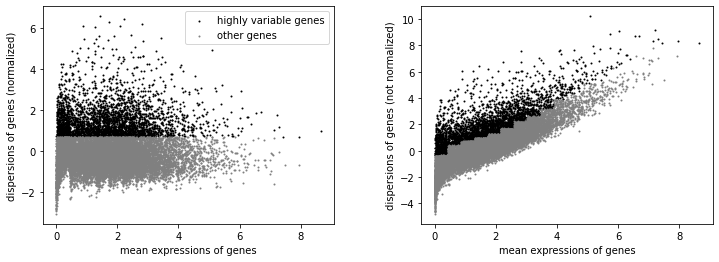

In [13]:
adata = sc.AnnData(X=df.transpose(), obs=df_files.reindex(index=df.columns))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
hvg = adata.var[adata.var["highly_variable"]==True].index

In [14]:
df.reindex(index=hvg).to_csv("mainTable.csv", index=True, header=True)

### sbmtm

In [15]:
from sbmtm import sbmtm

ModuleNotFoundError: No module named 'sbmtm'

In [ ]:
hsbm = sbmtm()

In [ ]:
hsbm.make_graph_from_BoW_df(df.reindex(index=hvg))

In [ ]:
hsbm.save_graph("graph_hv.xml.gz")

In [ ]:
del hsbm
gc.collect()

# Merged

In [16]:
df_merged = pd.read_csv("../../merged/files.dat", index_col=0)
df_query = pd.read_csv("../../merged/files.txt",sep="\t")
df_query.set_index("cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id", inplace=True)

In [17]:
df_merged["Subtype"]=df_merged["status"]
df_merged["Type"]=df_merged["status"]
df_tmp = df_files.reset_index().set_index("cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id")
df_tmp=df_tmp[df_tmp.index.isin(df_merged.index)]
for sample in df_tmp.index:
    df_merged.at[sample,"Type"]=df_tmp.at[sample,"cancer.type"]
    df_merged.at[sample,"Subtype"]=df_tmp.at[sample,"Subtype_Selected"]
for sample in df_merged.index:
    if sample[:12] in df_query.index and df_merged.at[sample,"status"]=="tumor":
        df_merged.at[sample,"Type"]=df_query.at[sample[:12],"project.project_id"][-4:]
    if sample in df_discordant.values:
        df_merged.at[sample,"Type"]="Discordant_LUSC"
df_merged = df_merged.transpose().append(df_query.transpose(), ignore_index=False).transpose()

In [18]:
df_merged=df_merged[df_merged["primary_site"]=="Lung"]
df_merged.fillna(np.nan).to_csv("../merged_lung/files.dat")

# Stages

In [19]:
sys.path.append("/home/jovyan/work/phd")
from hsbmpy import get_file, get_next_color
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir("../merged_lung")
os.listdir("..")

['.DS_Store',
 'breast',
 'crectal',
 'files.dat',
 'luad_hd',
 'lung',
 'lusc_hd',
 'lusc_hv',
 'merged_lung',
 'pancreas',
 'TCGA_biolinks.csv']

In [20]:
l=1
algorithm = "topsbm"
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'stage','')
df_topics.insert(0,'type','')
df_topics.drop('i_doc', axis=1, inplace=True)
#labels = ["cases.0.diagnoses.0.tumor_stage","cancer.type"]
labels=["cases.0.diagnoses.0.tumor_stage","Type"]
label = labels[0]
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'stage']=("%s"%(get_file(sample,df_files)[labels[0]]))
    df_topics.at[sample,'type']=("%s"%(get_file(sample,df_files)[labels[1]]))

In [21]:
mask = df_topics["stage"]!="not reported"
mask = (mask) & (df_topics["type"].isin(["LUAD", "LUSC"]))
mask = (mask) & (df_topics["stage"]!="nan")
#mask = np.ones(df_topics.shape[0],dtype=int)==1
df_topic_stage_gb = df_topics[mask].groupby(["type", "stage"])

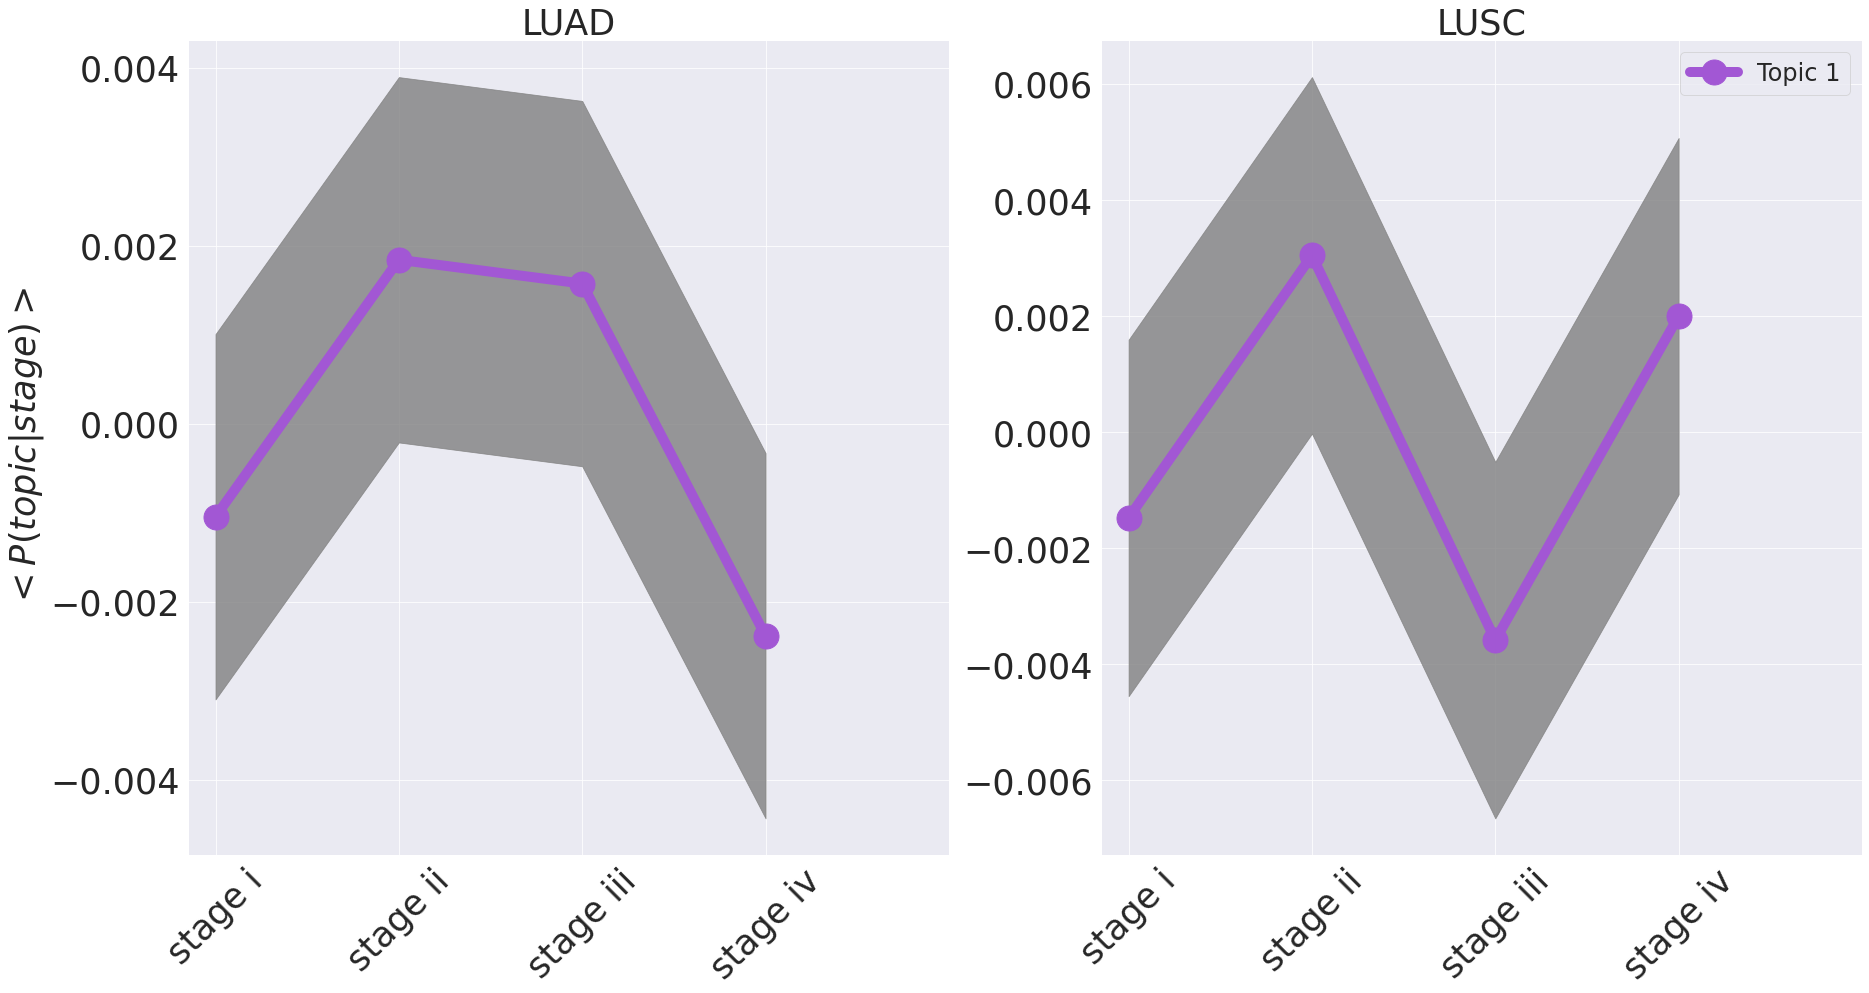

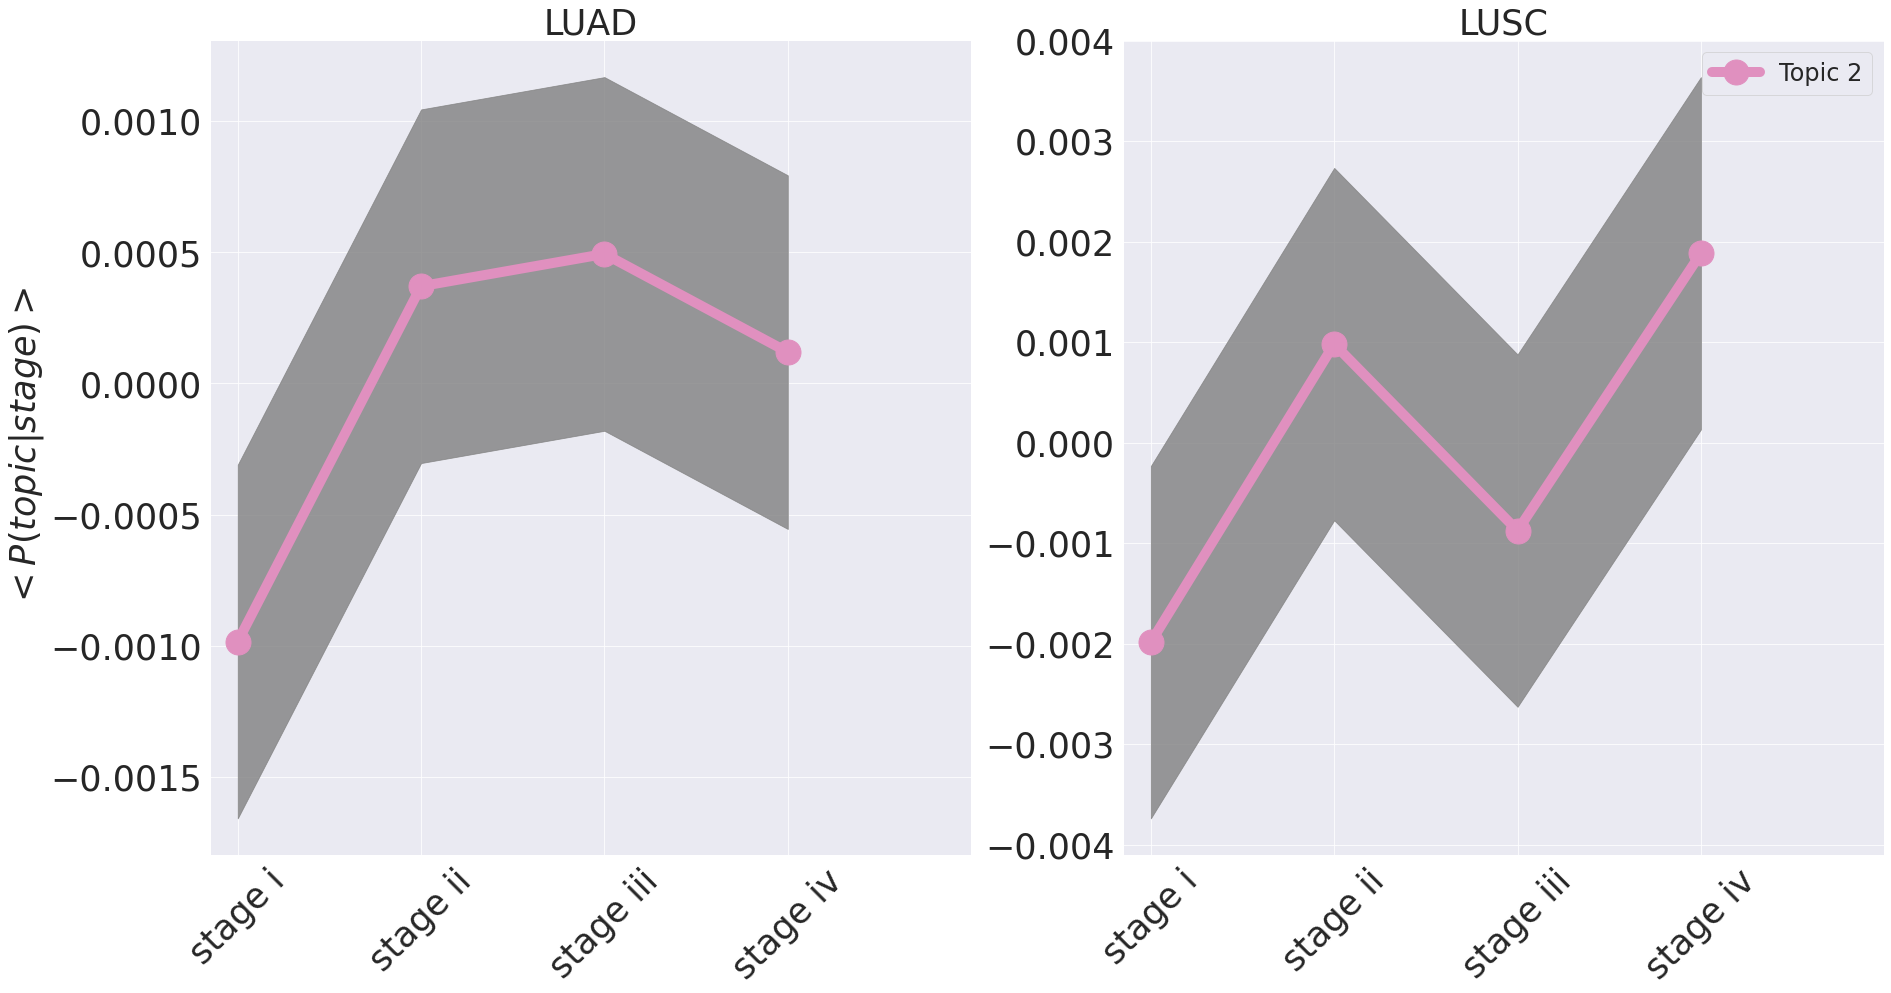

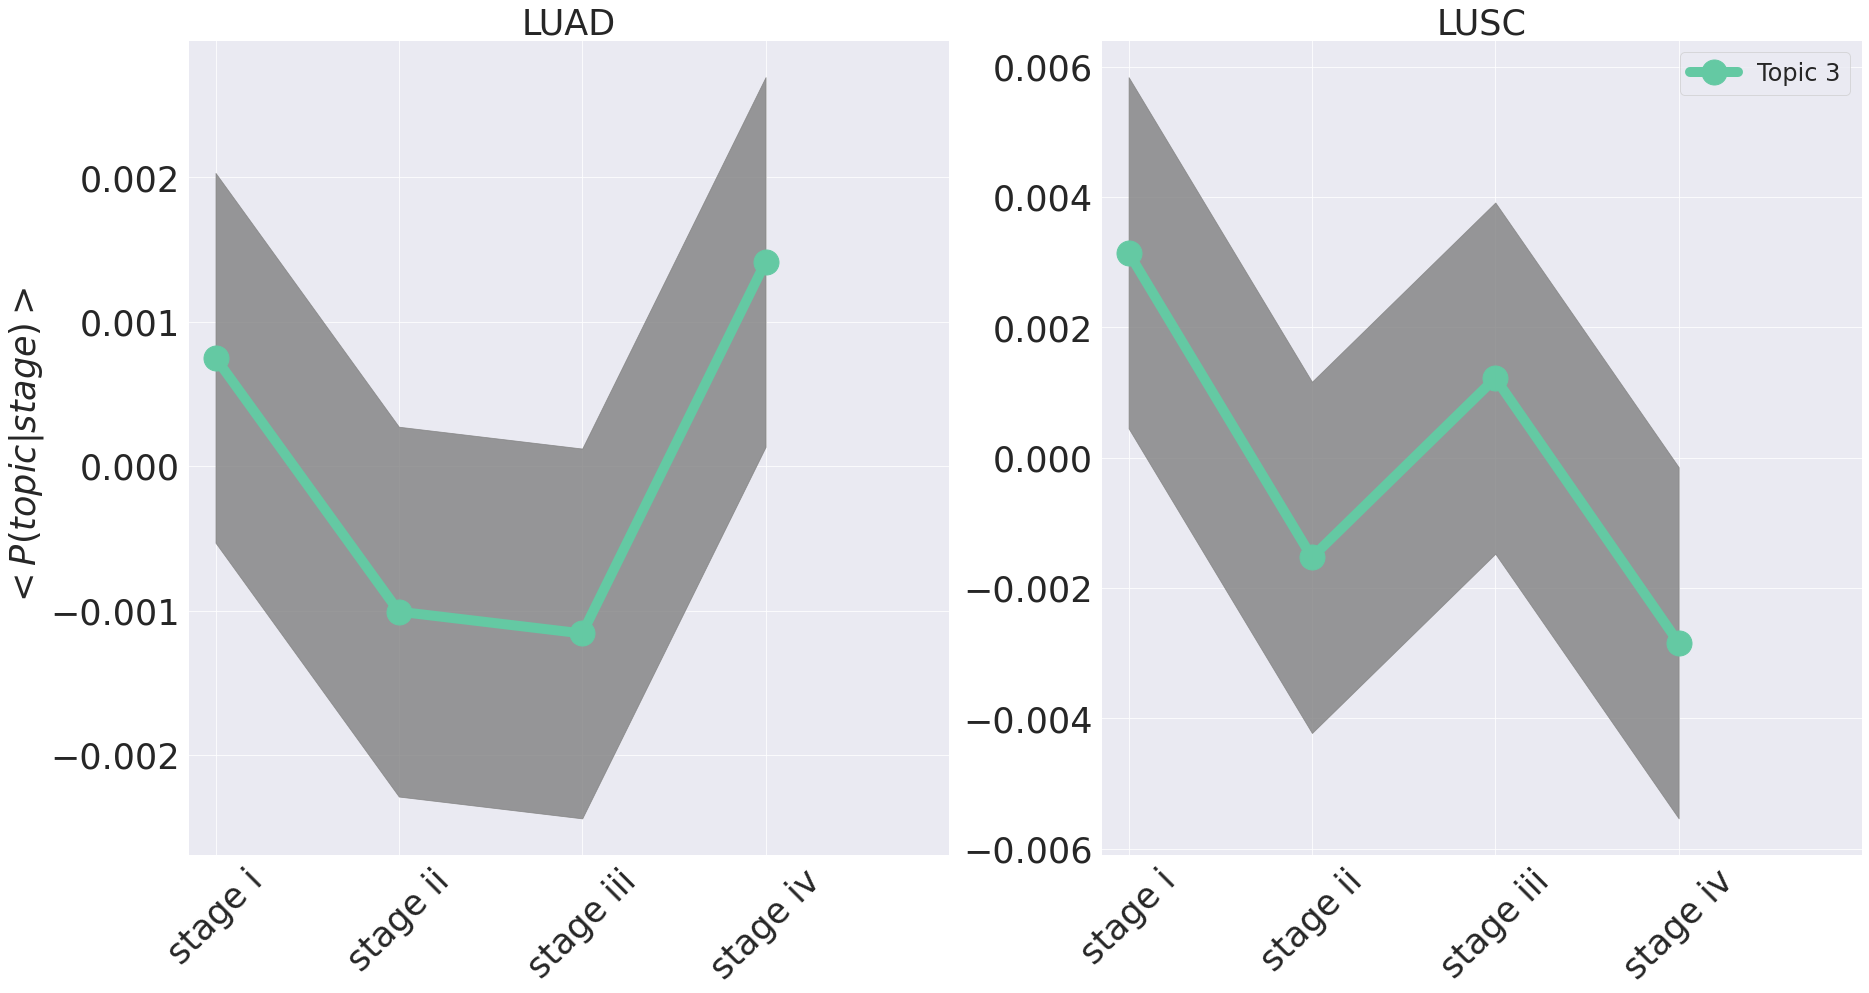

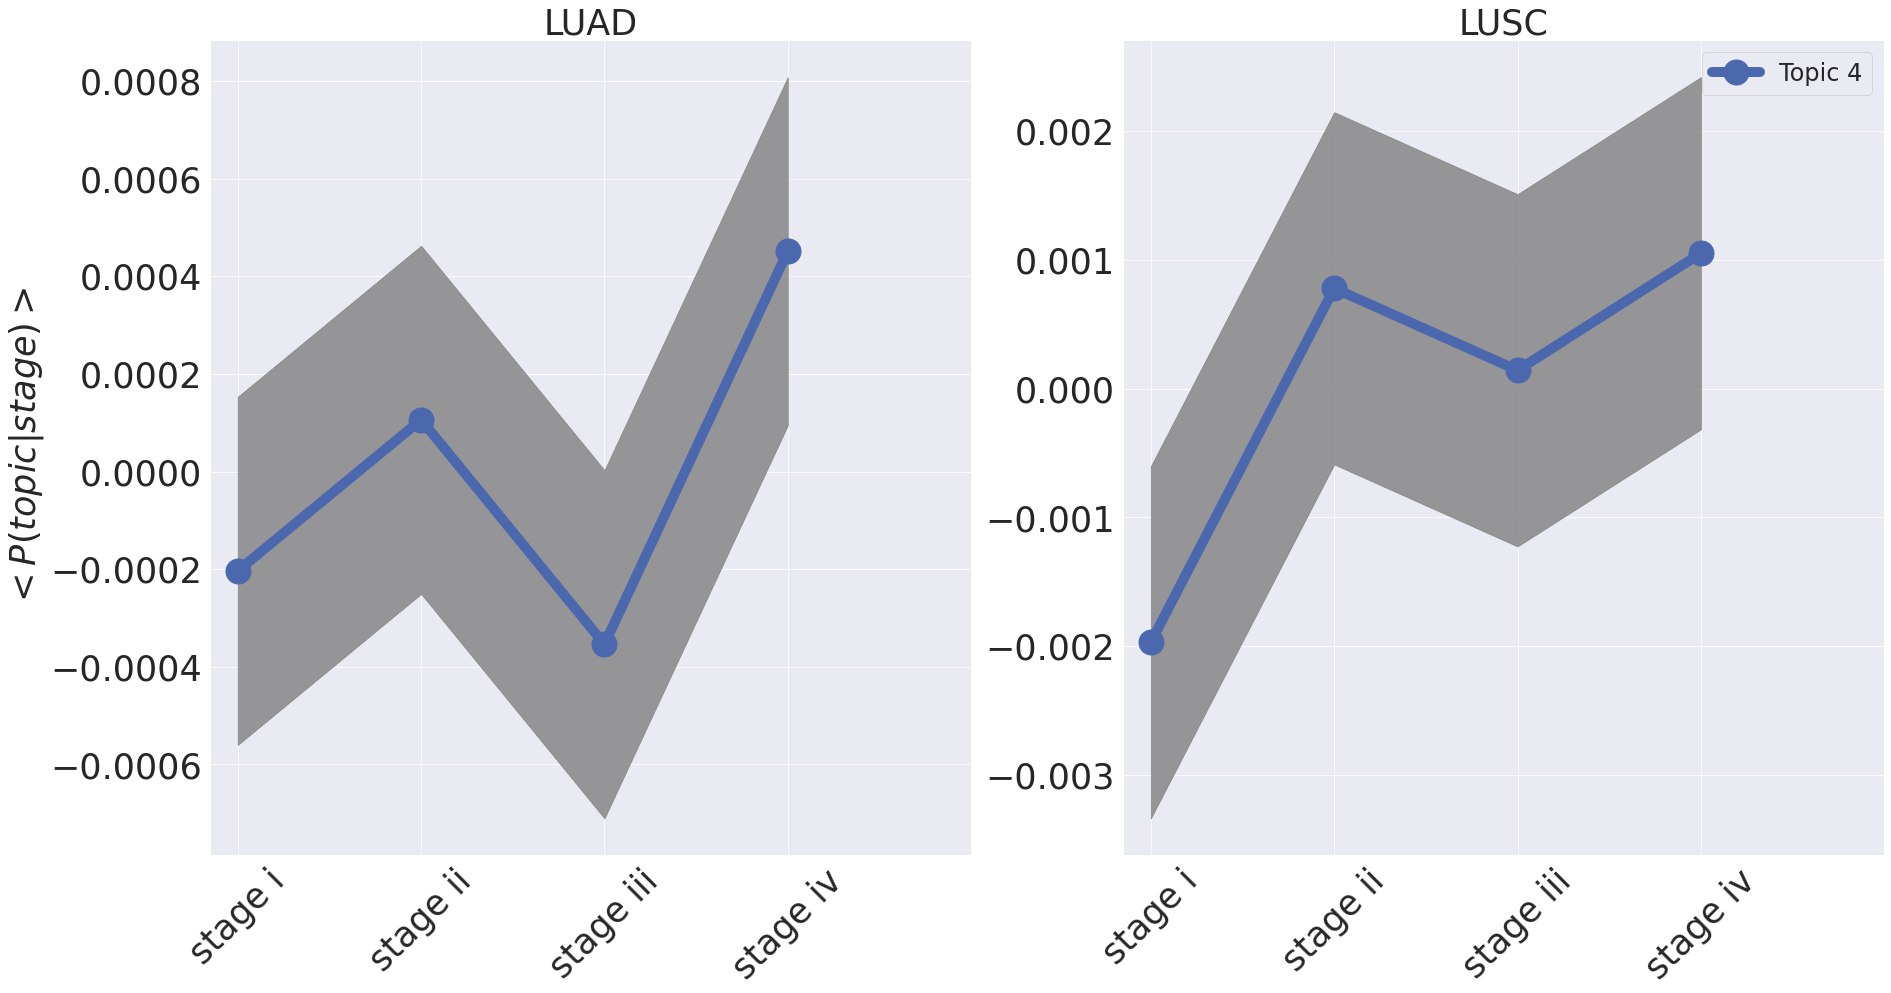

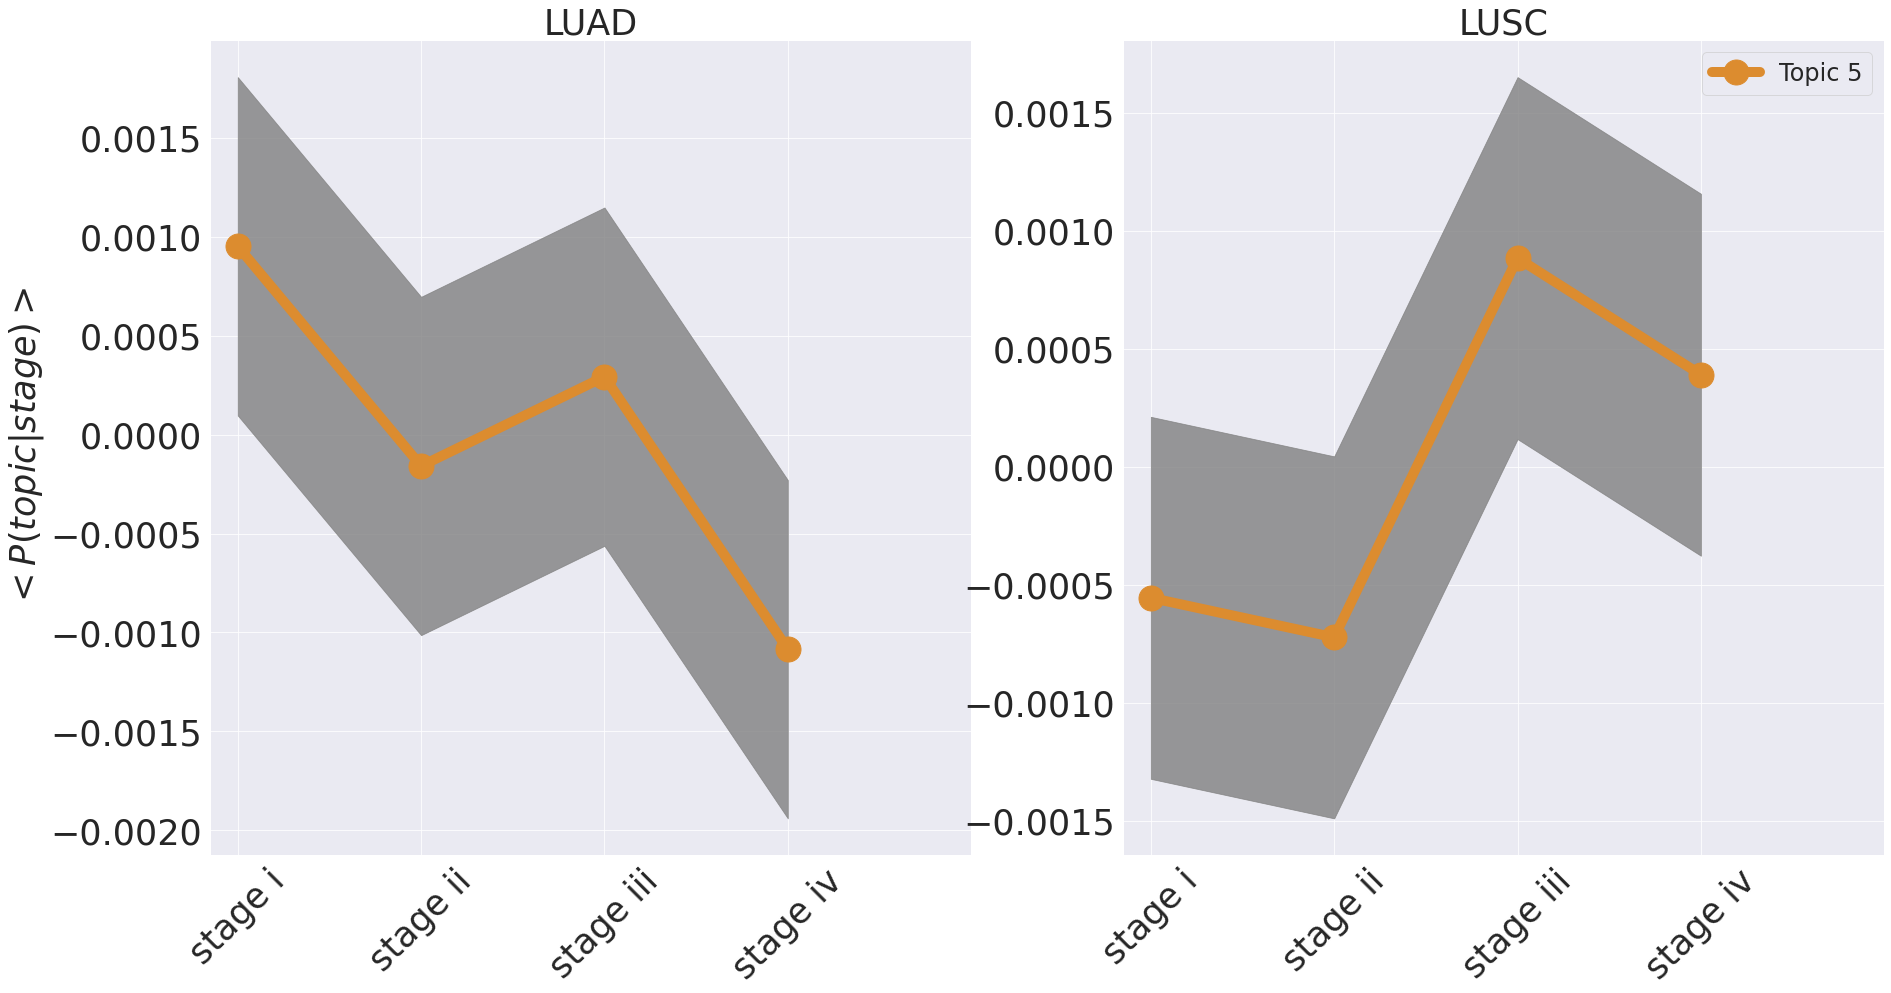

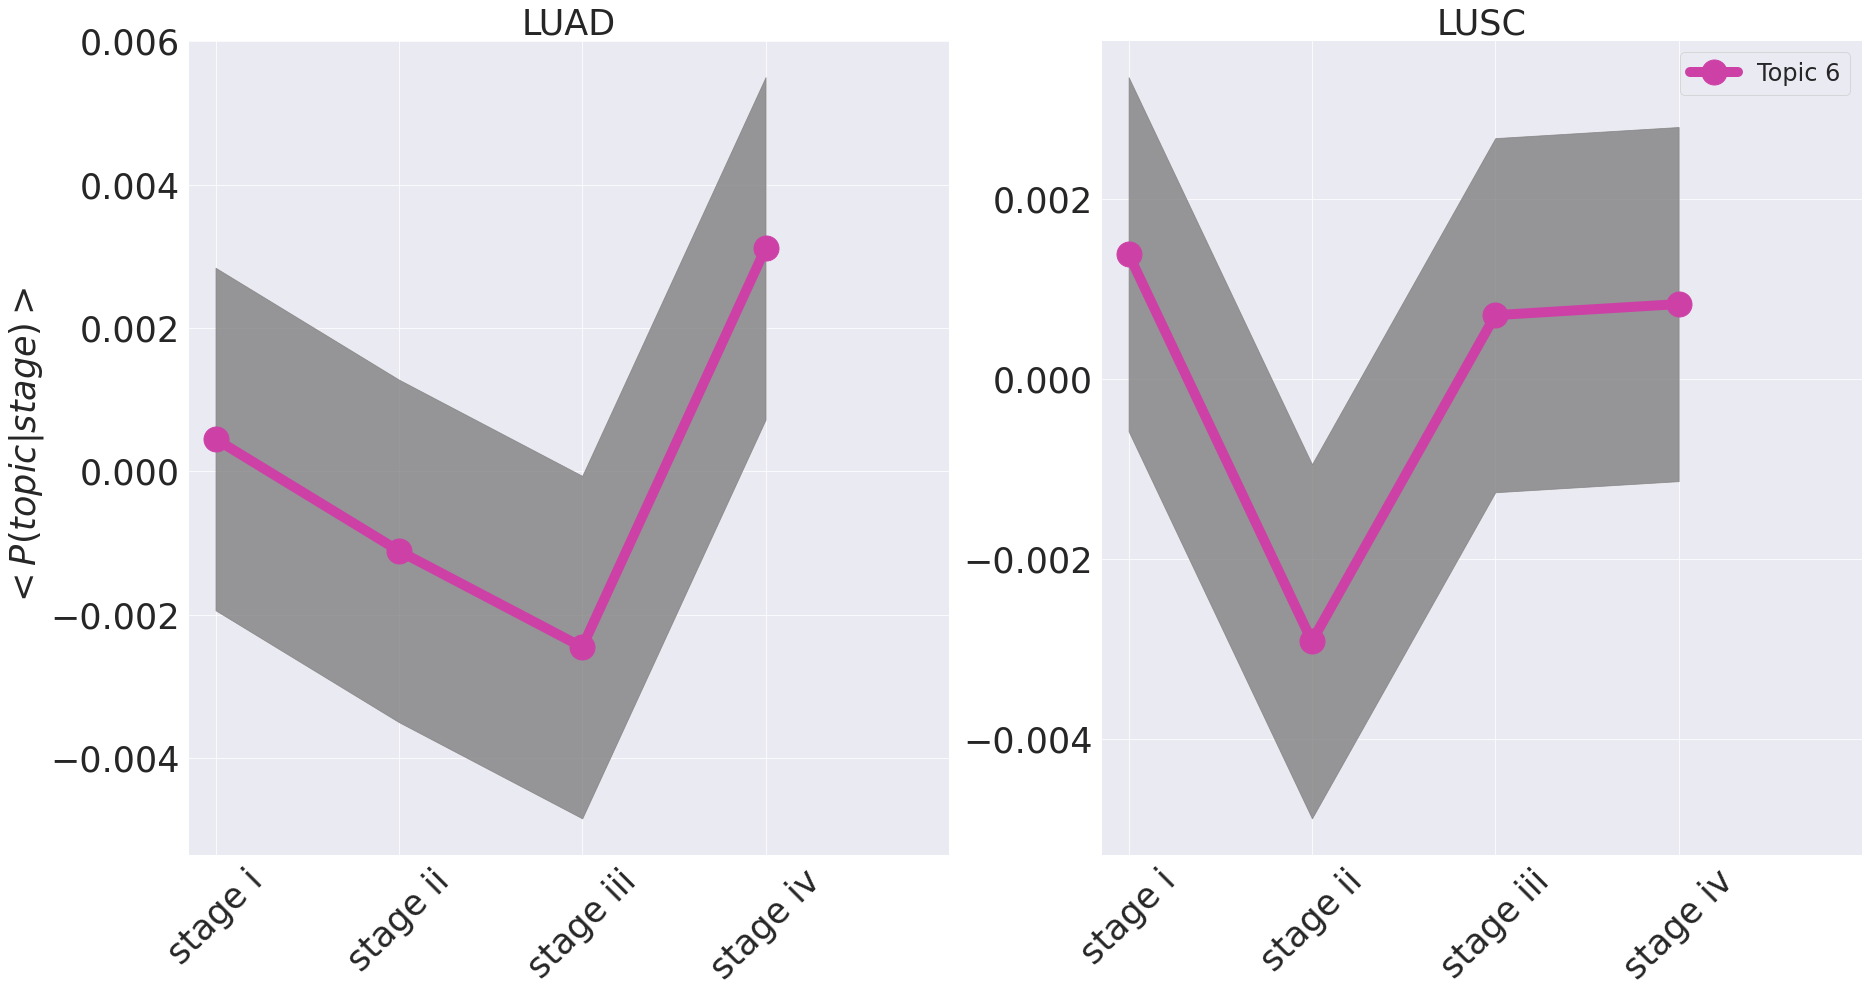

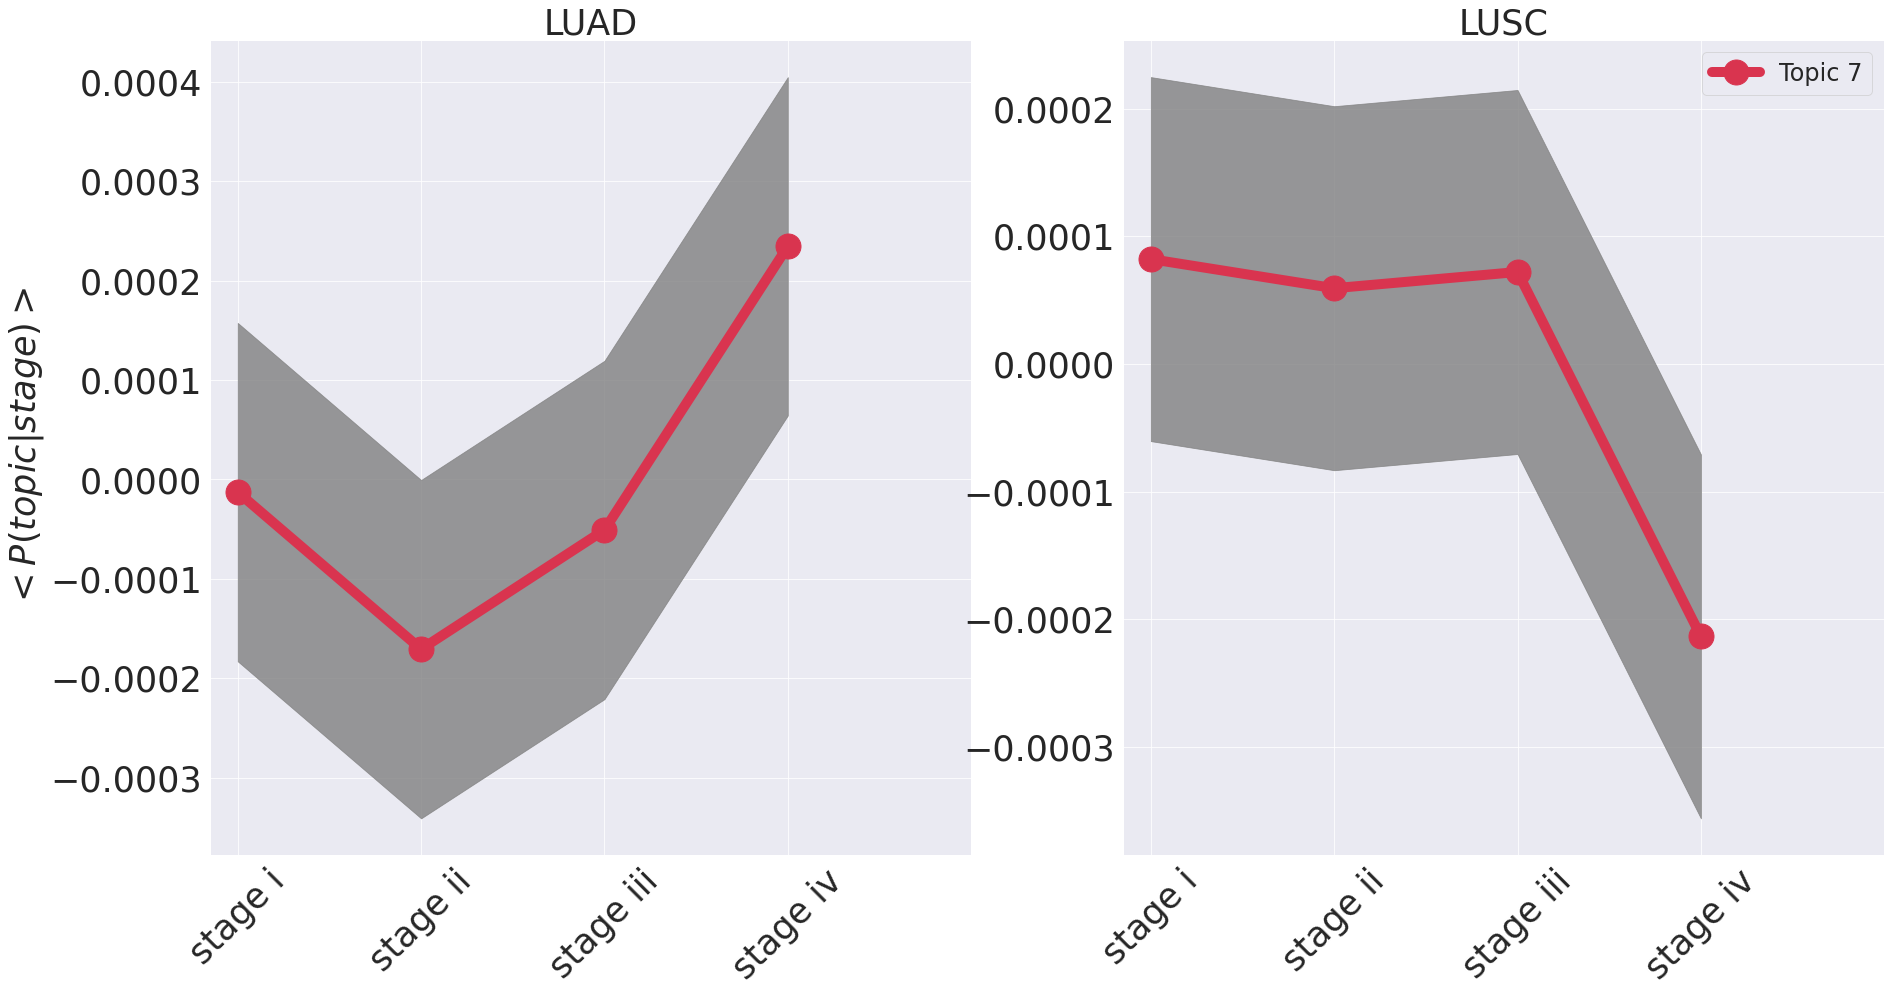

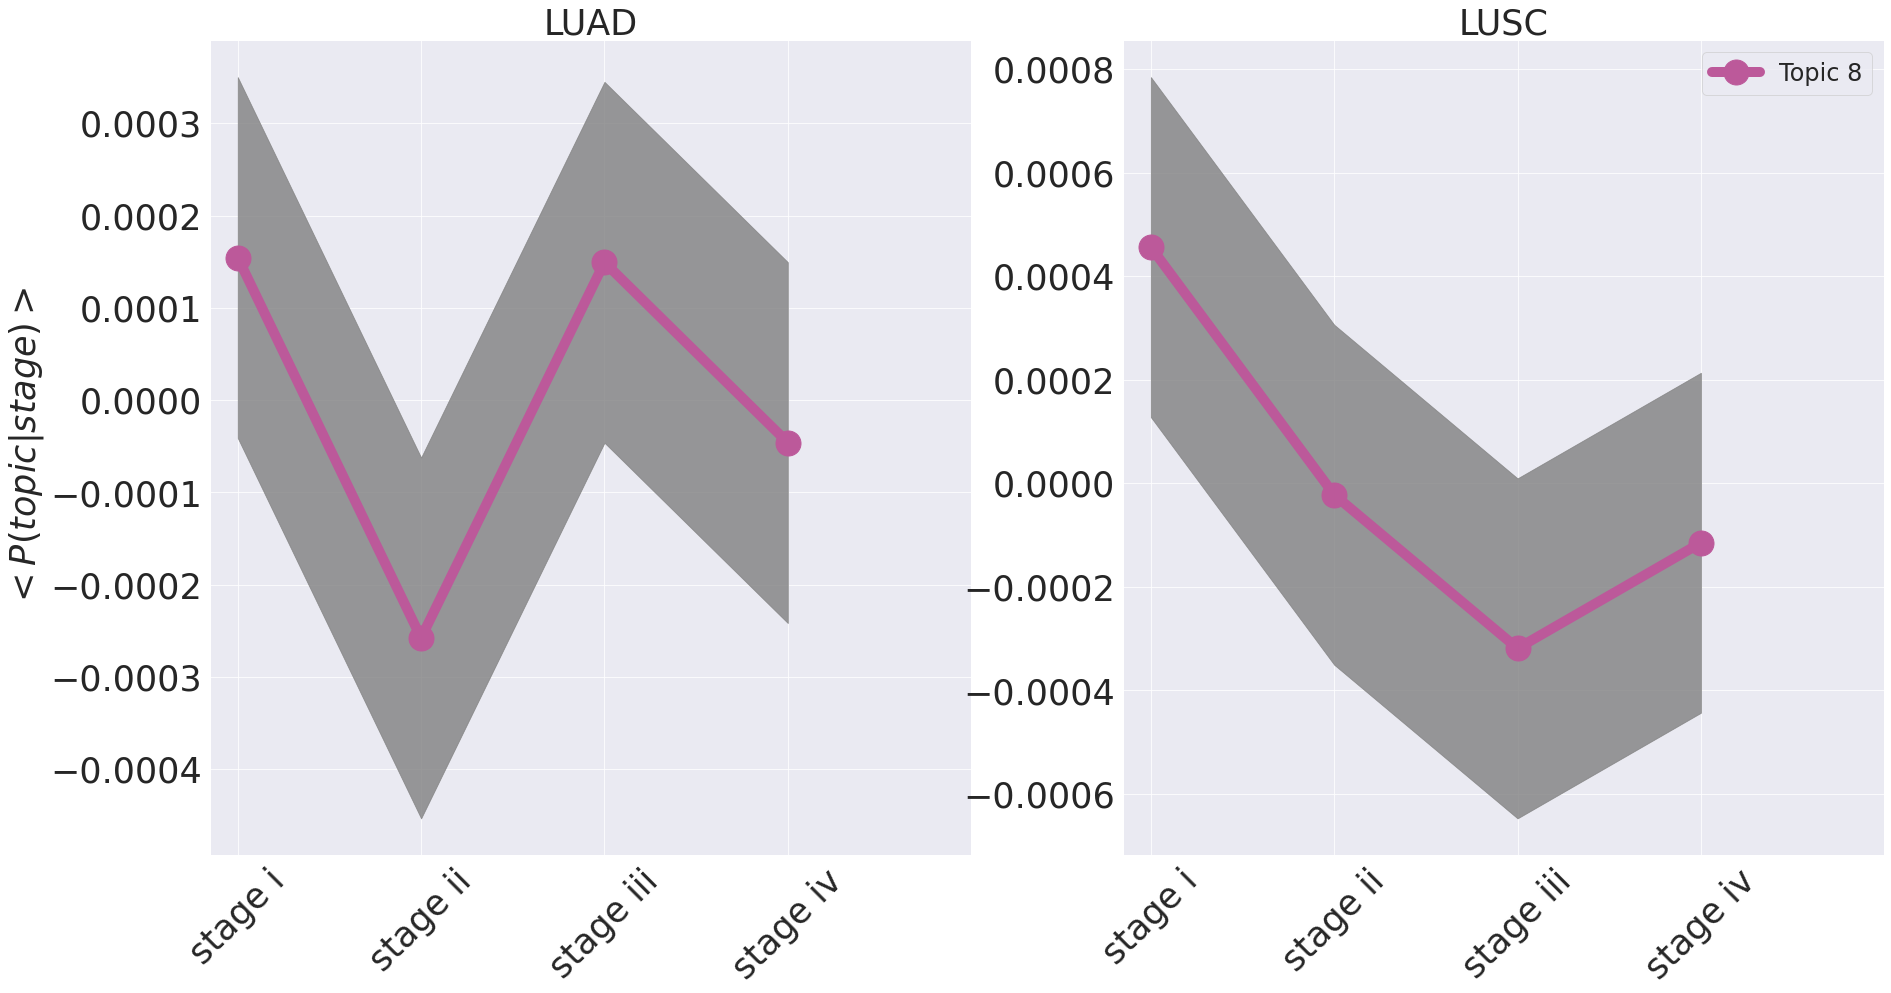

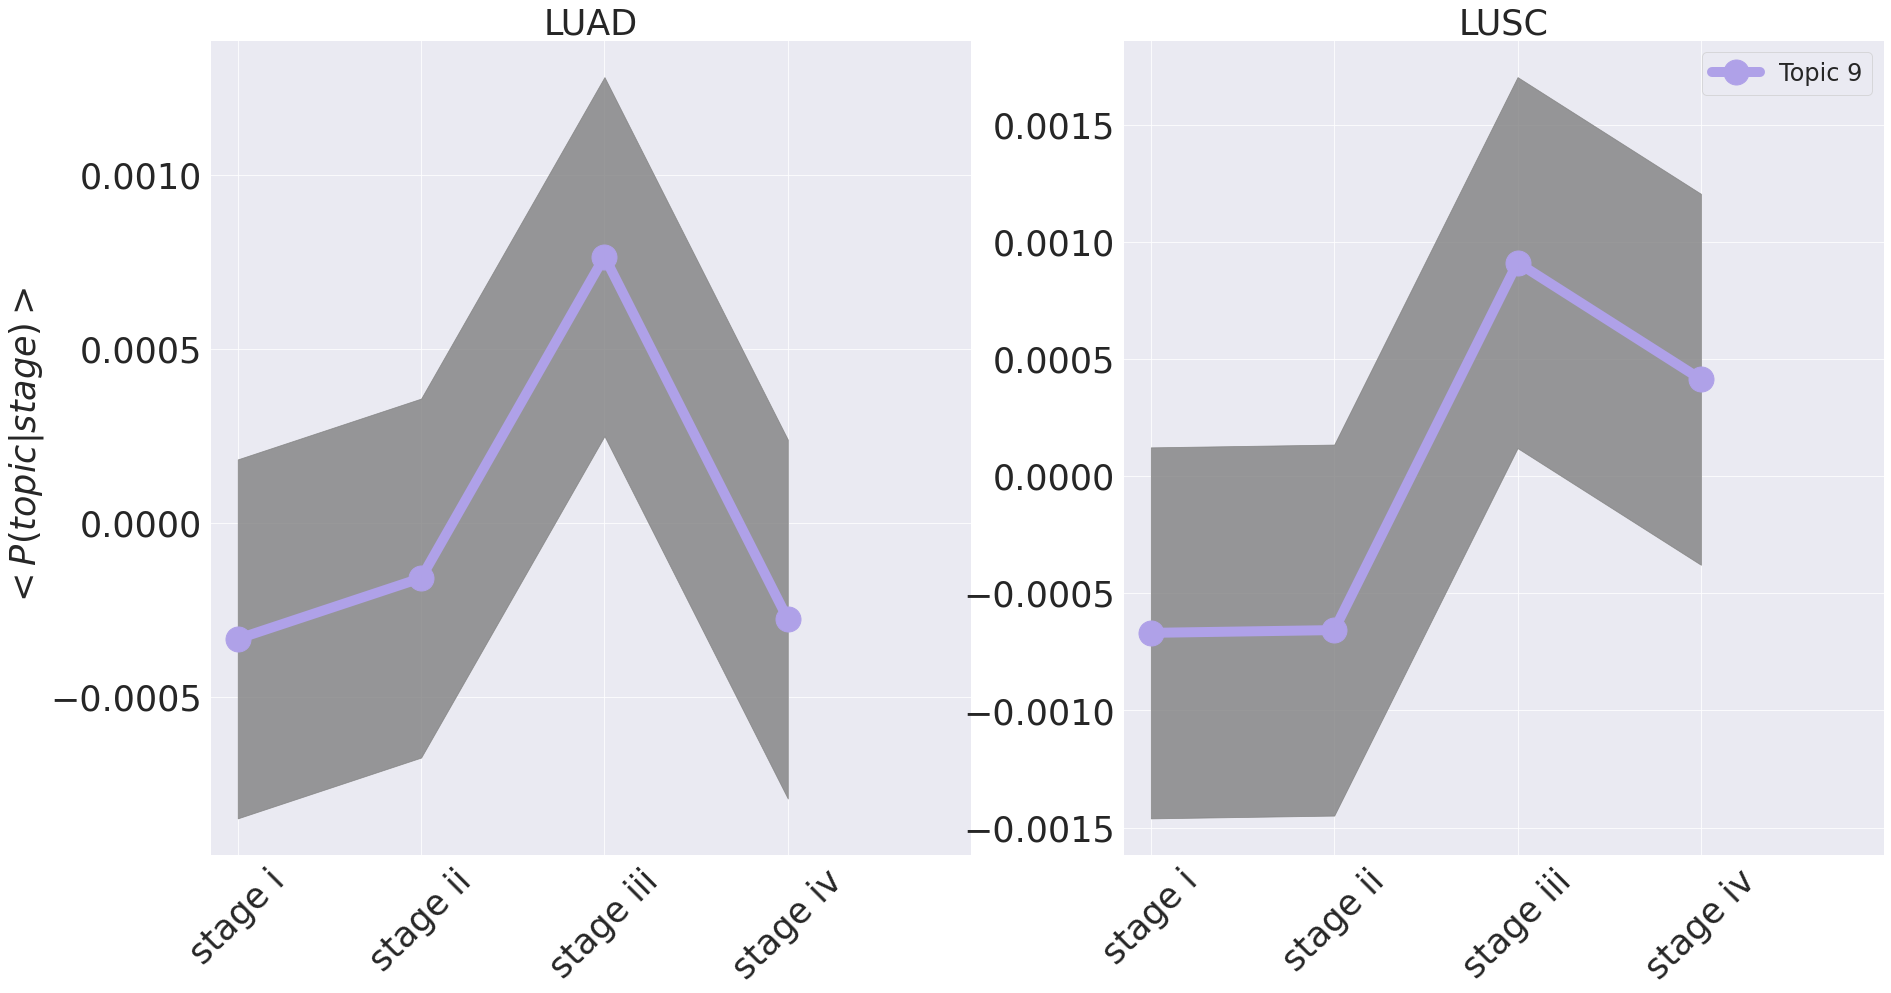

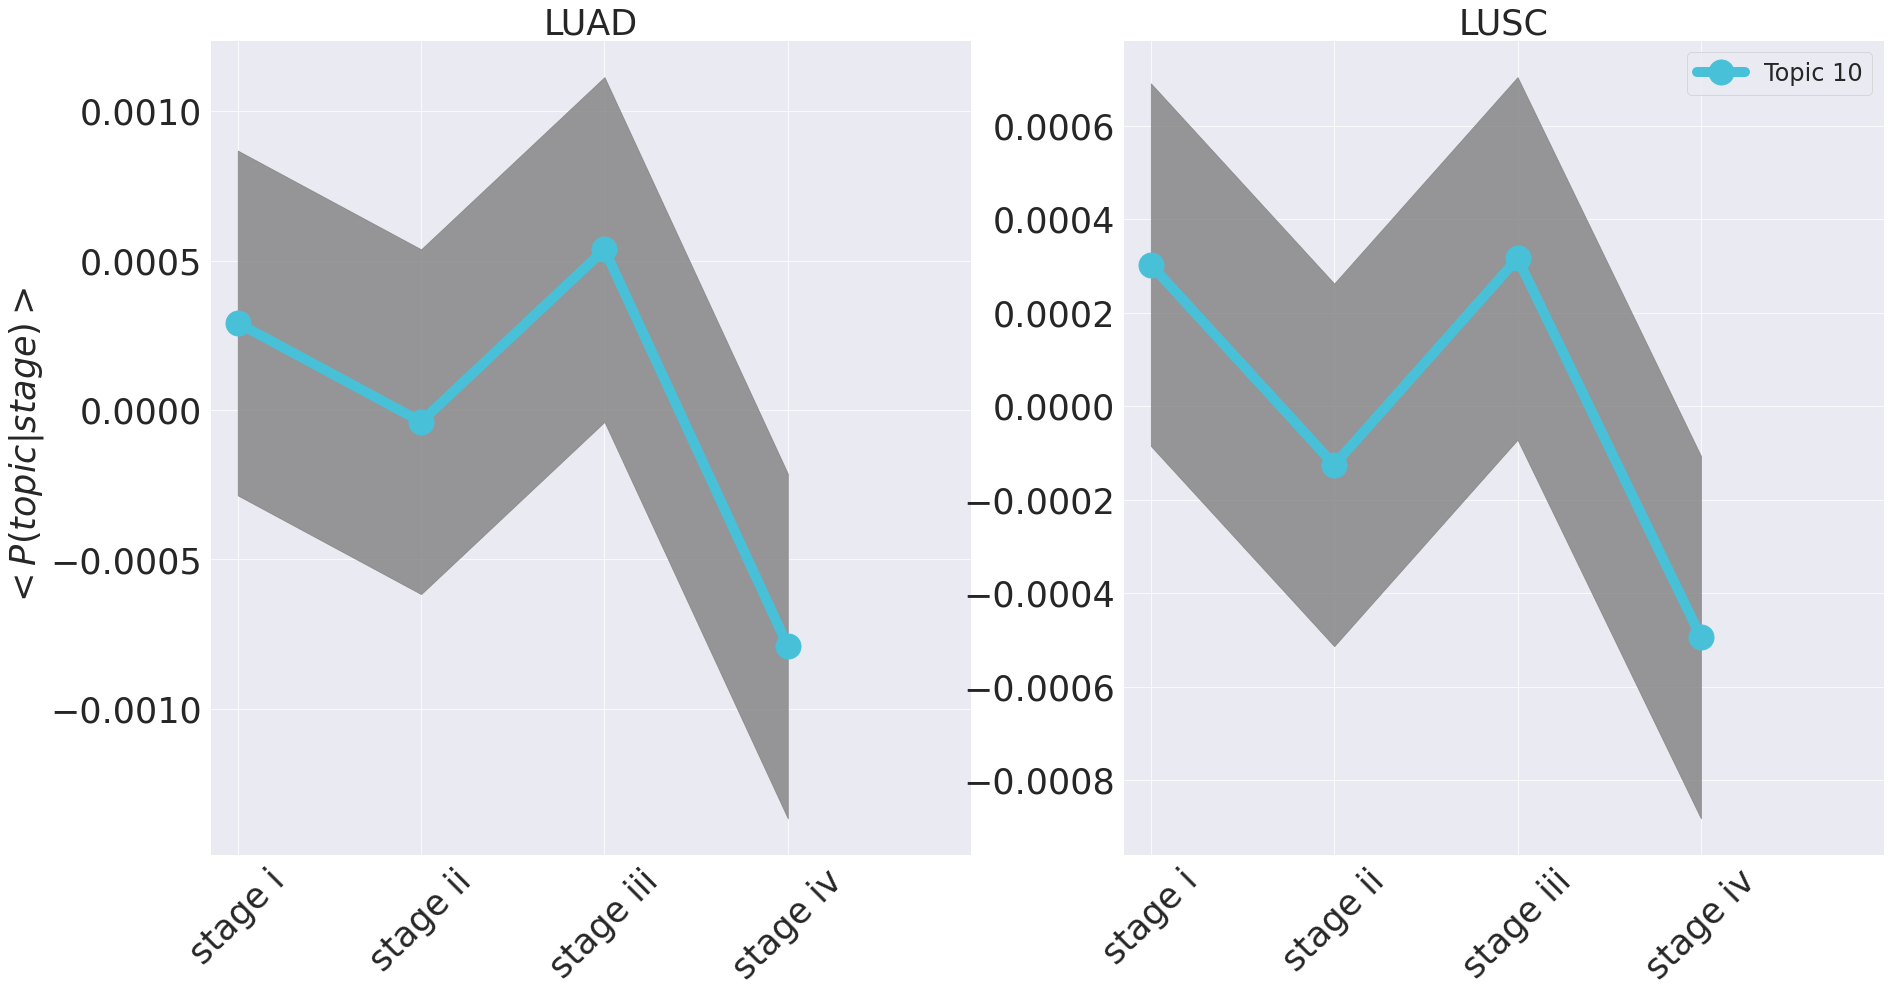

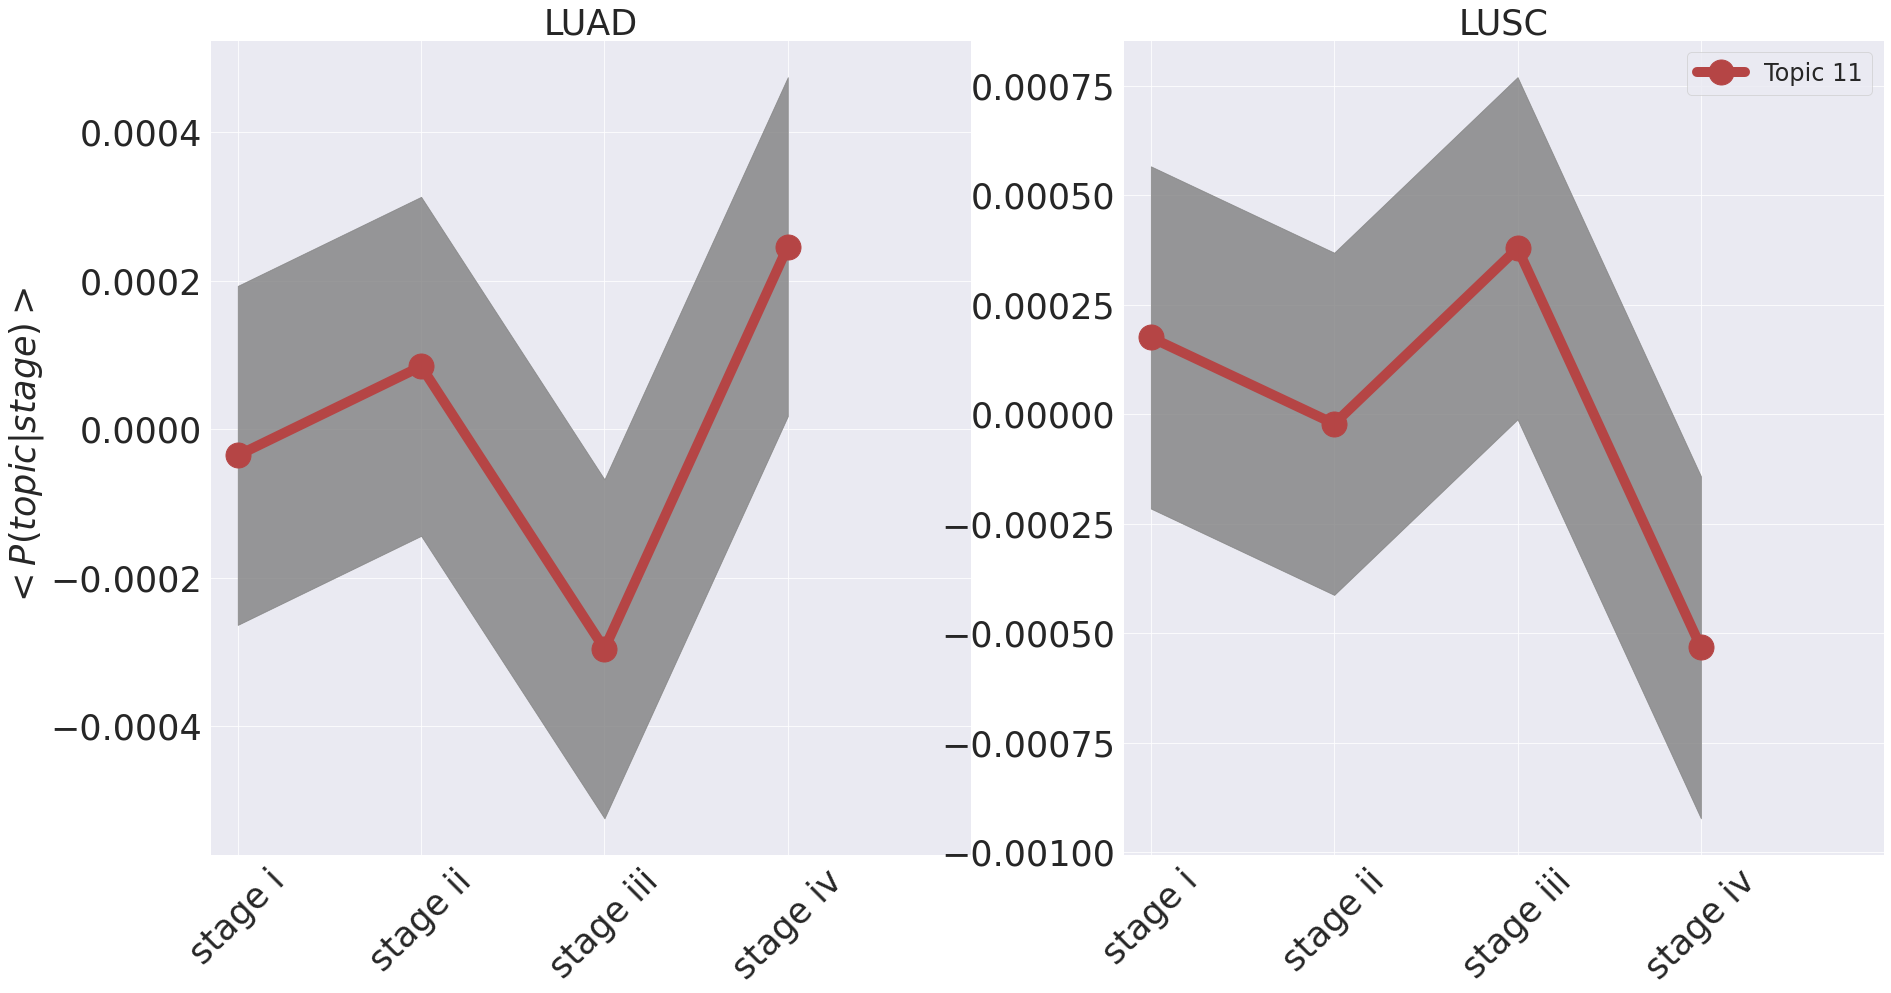

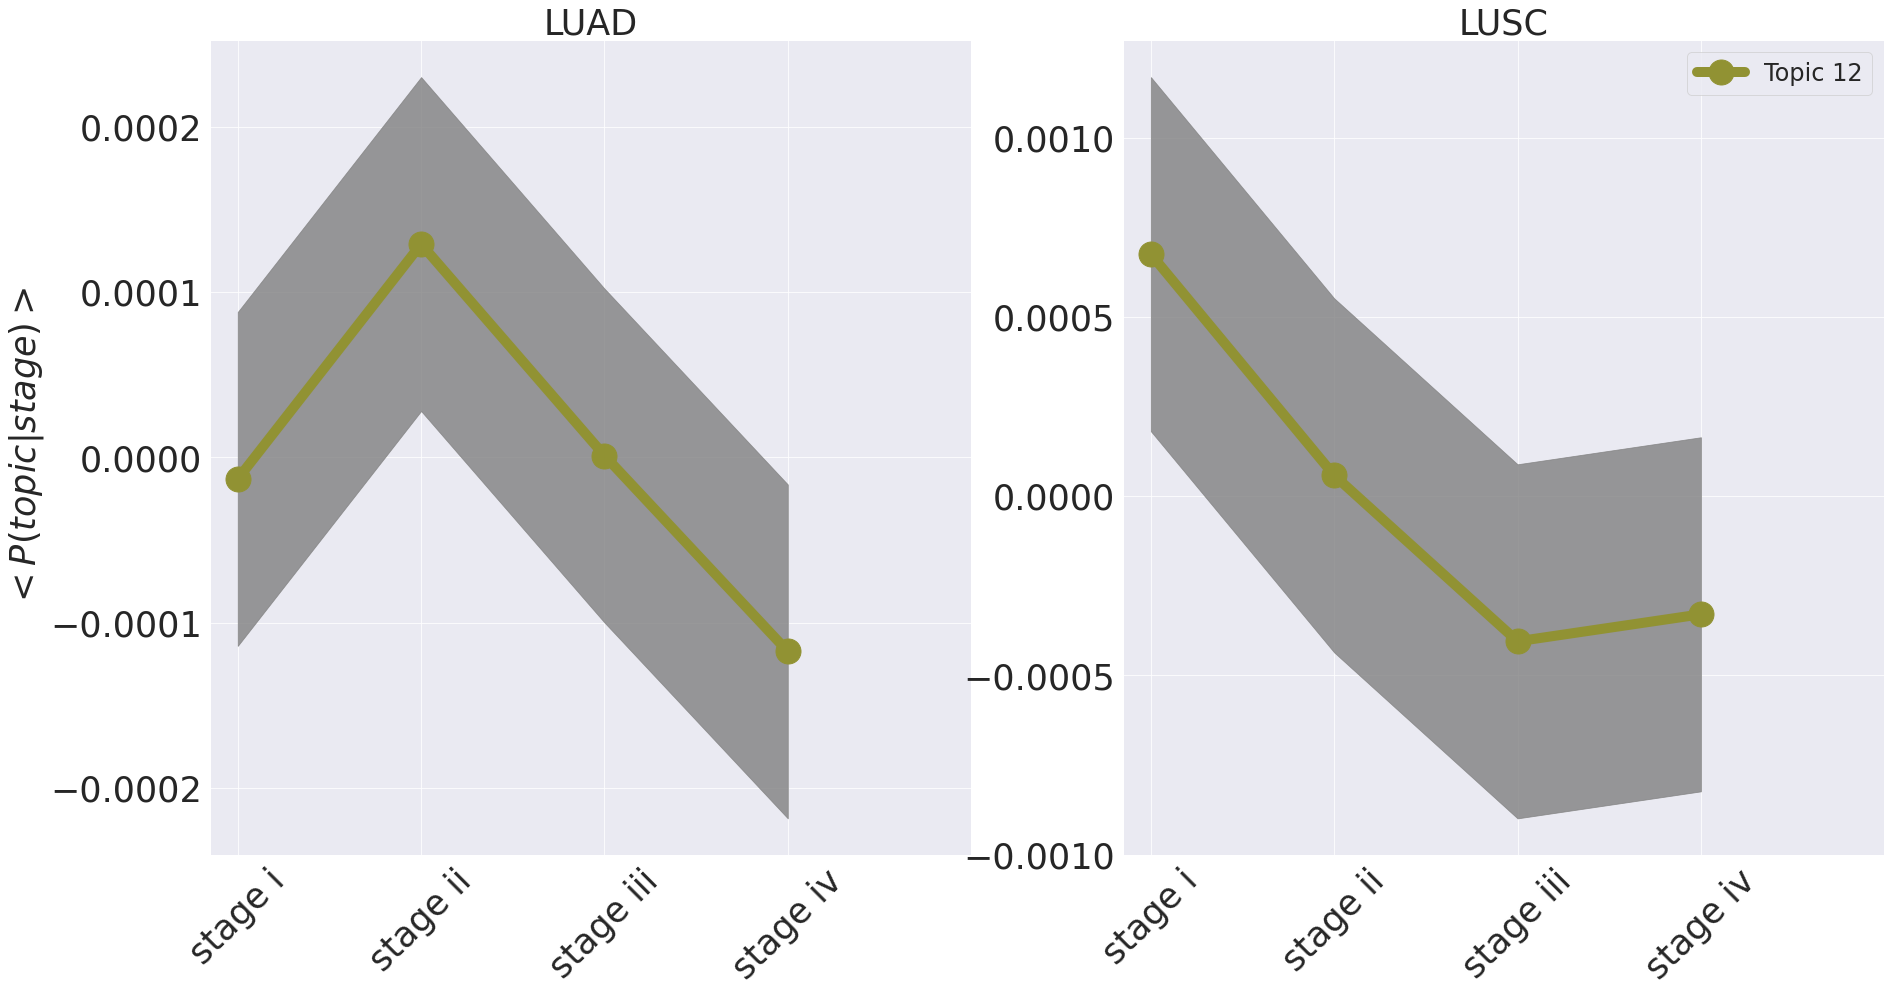

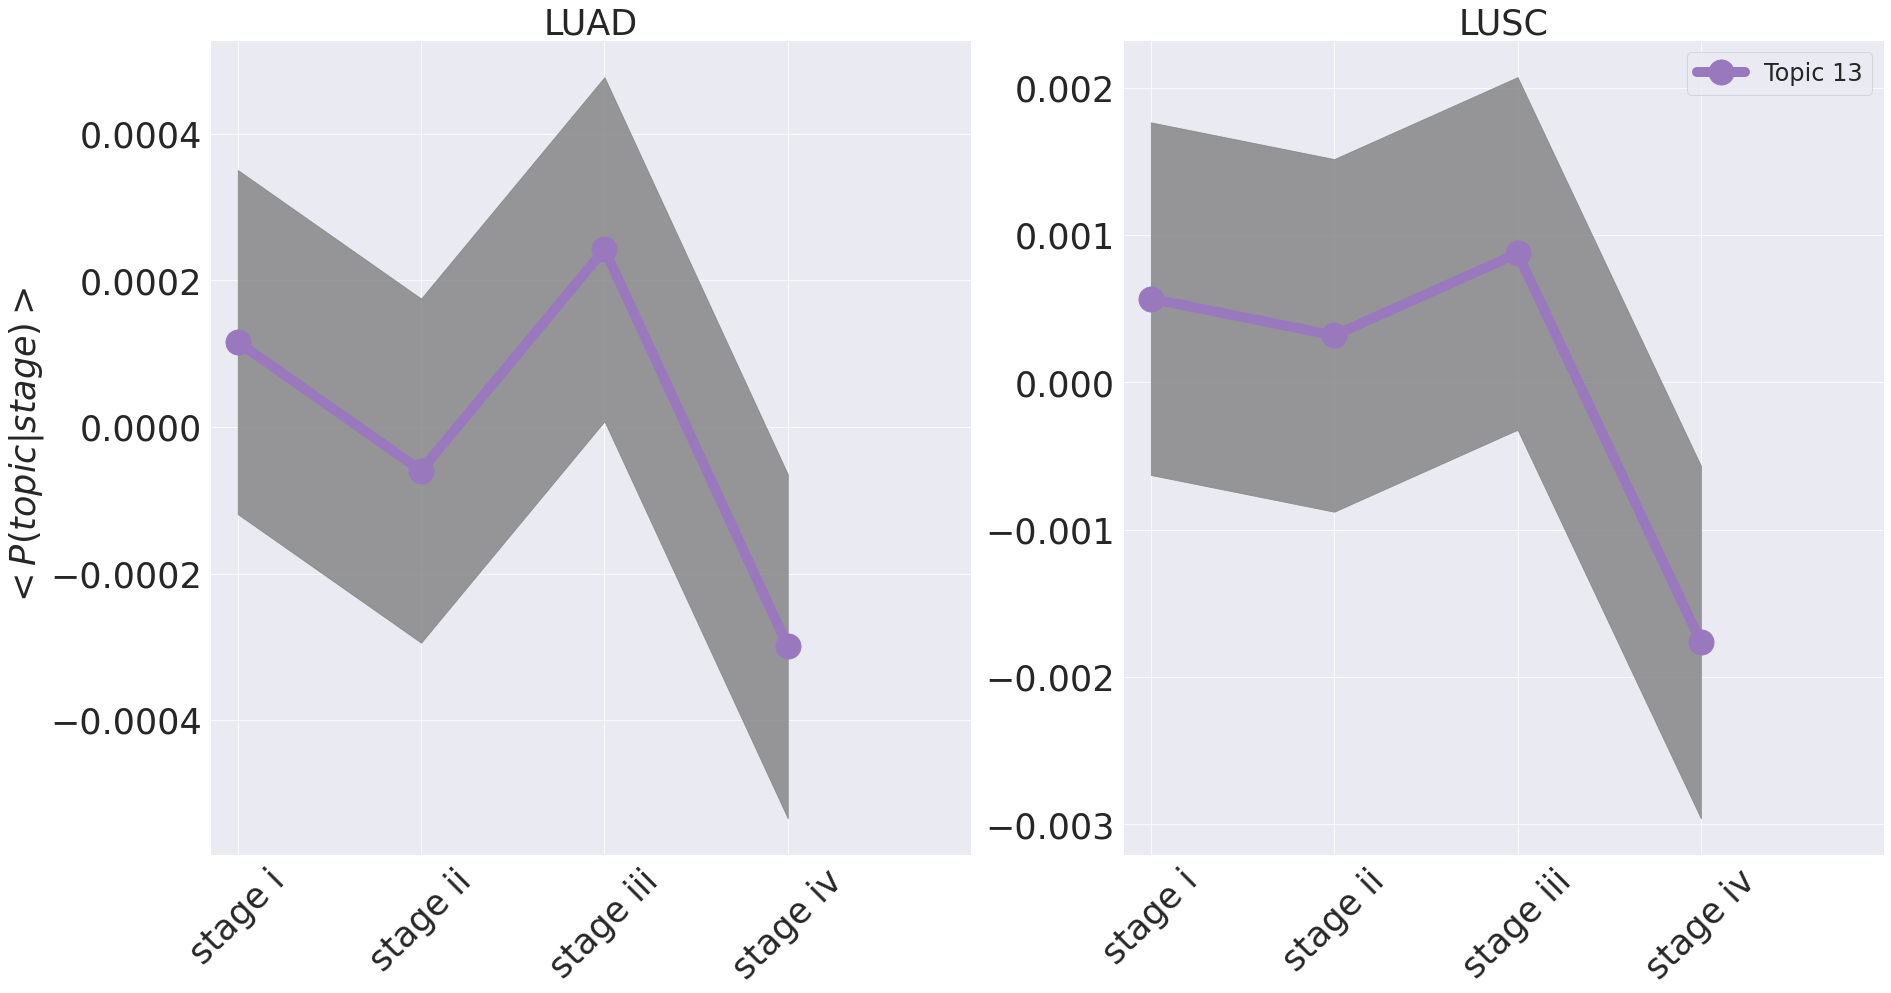

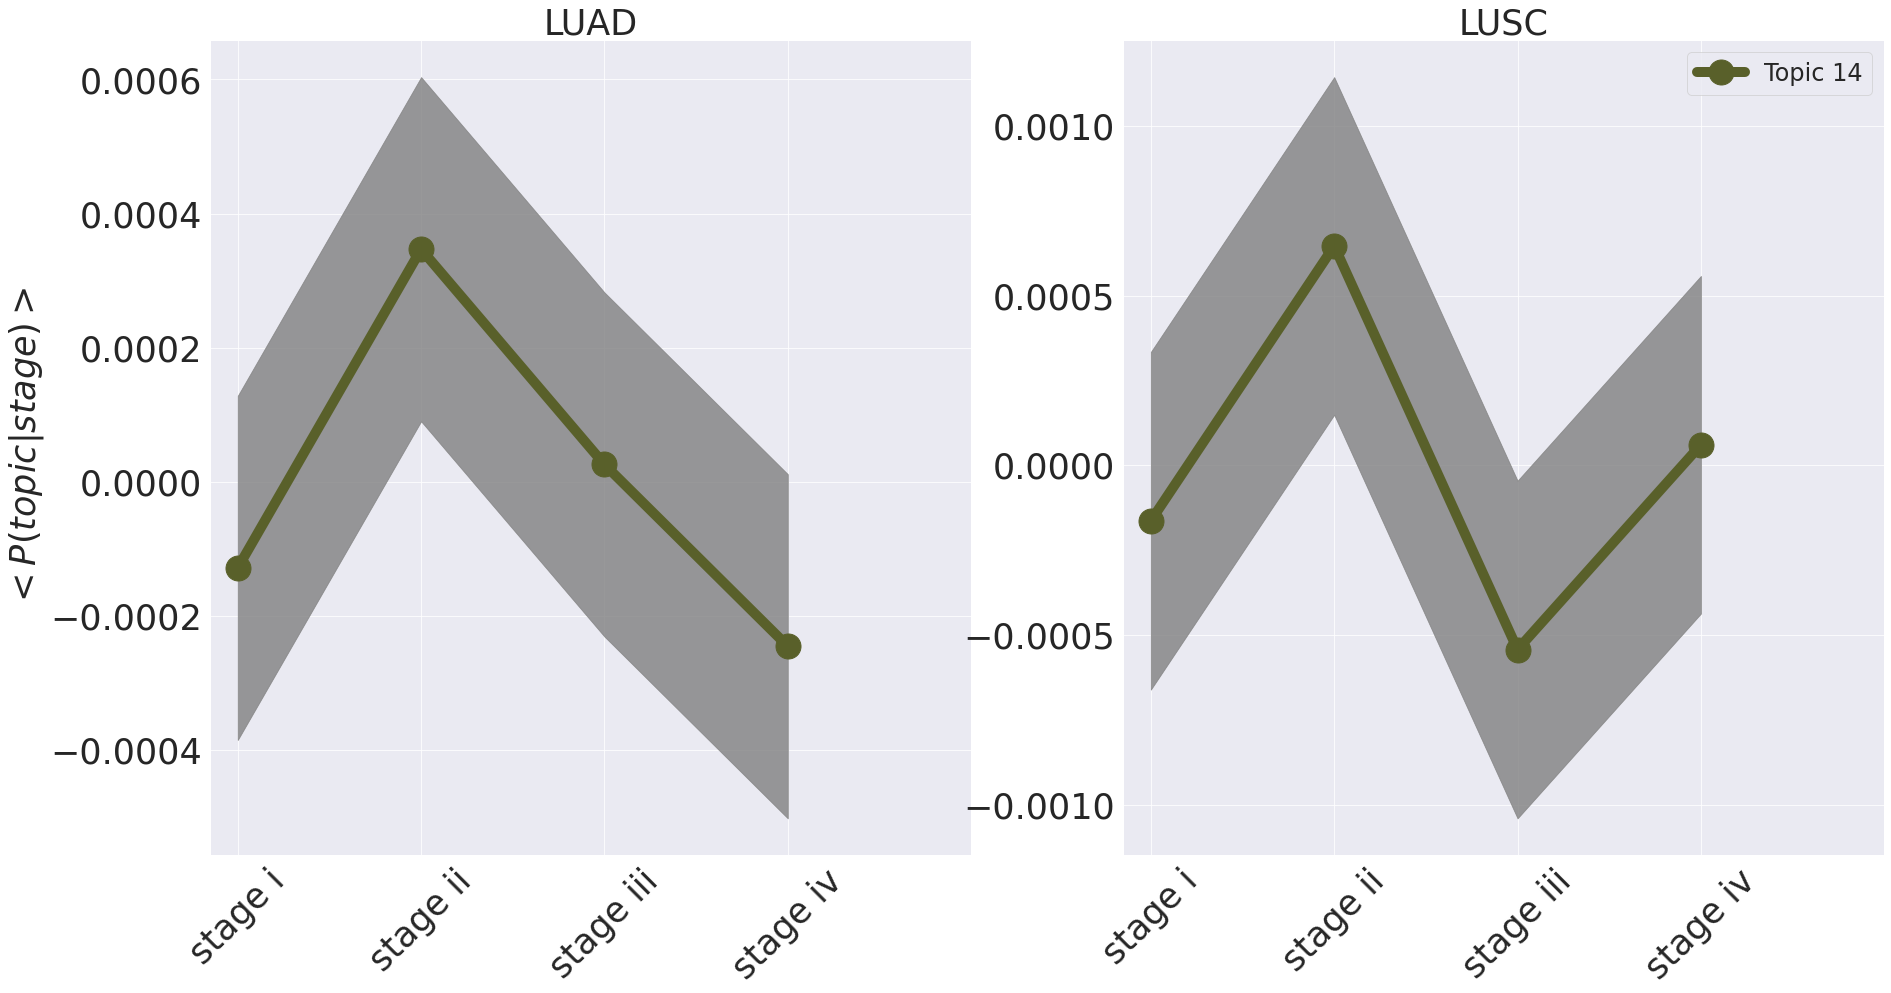

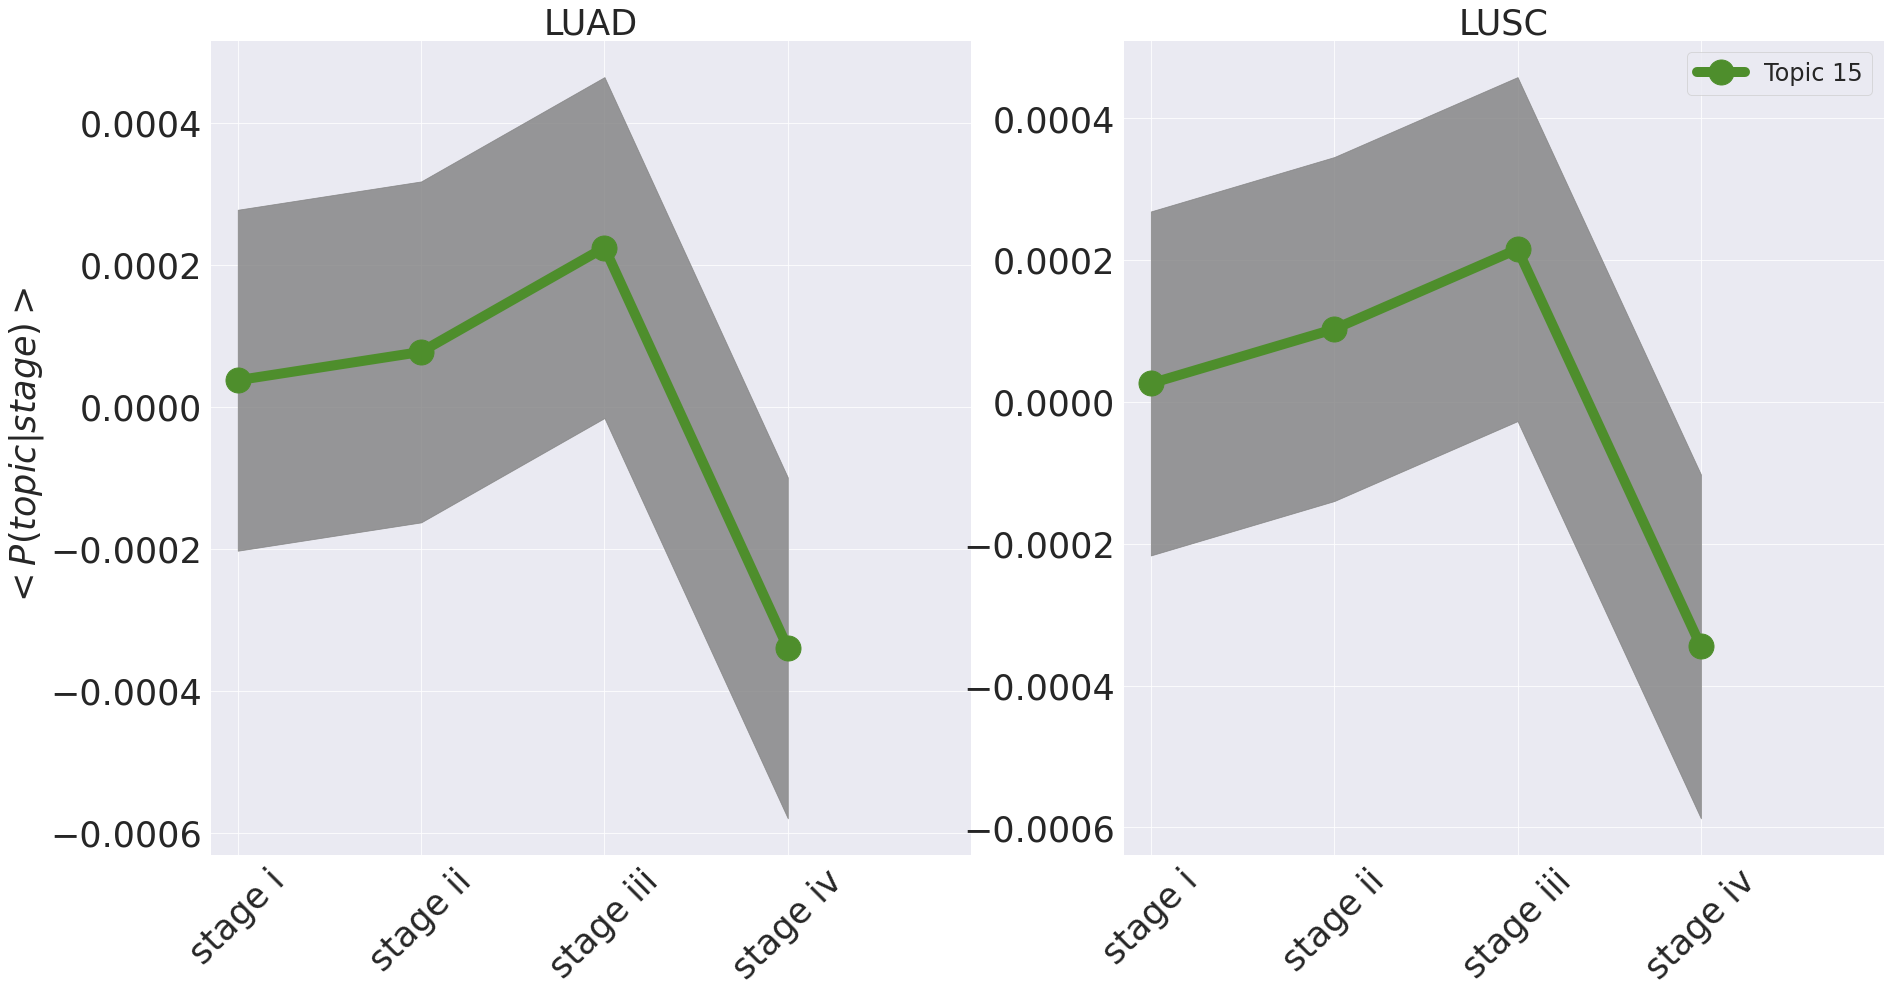

In [23]:
color_generator = get_next_color()
df_topic_stage = df_topic_stage_gb.mean()

for topic in df_topic_stage.columns:
    fig, axs = plt.subplots(1,2,figsize=(30,15))
    color = next(color_generator)
    for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index if ("Discordant" not in idx[0]) and ("healthy") not in idx[0]])), axs):
        idxs = int(round(df_topic_stage.index.shape[0]/2))
        idx = df_topic_stage.index[i*idxs:(i+1)*idxs]
        
        df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
        mean = df_topic_stage_dat.mean(0).values[0]
        df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
        #sigma = df_topic_stage_dat.std(0).values[0]
        #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
        df_topic_stage_dat.plot(ax=ax, marker="o",ms=25, lw=10, c=color, legend=False)
        
        x = ax.lines[0].get_xdata()
        y = ax.lines[0].get_ydata()
        err = (df_topic_stage_dat.std(0)).values.ravel()
        ax.fill_between(ax.lines[0].get_xdata(), y-err, y+err, color="gray", alpha=0.8)
        
        
        labs = np.sort(df_topics[mask]["stage"].unique())
        ax.set_xticklabels(labels=labs, rotation=45)
        ax.set_xticks(np.linspace(0,len(labs),len(labs)+1))
        ax.tick_params(labelsize=35)
        ax.set_title(dataset, fontsize=35)
        ax.set_xlabel("")
        
    axs[1].legend(fontsize=24, ncol=3)
    axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)
    fig.savefig(f"topic_luad_lusc_{topic}.pdf")

    plt.show()

In [ ]:
topic = "Topic 3"
df_single_topic = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).sort_values([topic], ascending=False)[topic].dropna()
for g in df_single_topic[df_single_topic>df_single_topic[df_single_topic>0].quantile(0.75)].index:
    print(g,df_single_topic.at[g])

In [ ]:
df_single_topic[df_single_topic>df_single_topic[df_single_topic>0].quantile(0.75)].to_csv("topic_3_lung.csv")

In [ ]:
import requests
with requests.get("https://david.ncifcrf.gov/data/download/conv_4D3189EEAD7F1588155942290.txt") as req:
    papaleo = [row.split("\t") for row in req.text.split("\n")]

In [ ]:
papaleo_ensg=list(zip(*papaleo[:-1]))[1][1:]

In [ ]:
np.array([g in papaleo_ensg for g in df_topics.values.ravel()]).any()

# MonteCarlo

In [ ]:
rs = np.random.RandomState(42)

color_generator = get_next_color()
df_topic_stage = df_topic_stage_gb.mean()

df_topics_mc = df_topics.copy()

topic="Topic 3"
fig, axs = plt.subplots(1,2,figsize=(30,15))
color = next(color_generator)
for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index if ("Discordant" not in idx[0]) and ("healthy") not in idx[0]])), axs):
    idxs = int(round(df_topic_stage.index.shape[0]/2))
    idx = df_topic_stage.index[i*idxs:(i+1)*idxs]

    df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
    mean = df_topic_stage_dat.mean(0).values[0]
    df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
    #sigma = df_topic_stage_dat.std(0).values[0]
    #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
    df_topic_stage_dat.plot(ax=ax, marker="o",ms=25, lw=10, c=color, legend=False)
    from sklearn.utils import shuffle
    
    errors = []
    for i in range(50):
        df_topics_mc["stage"] = shuffle(df_topics["stage"].values, random_state=rs)
        df_topics_mc_dat = df_topics_mc[mask].groupby(["type","stage"]).mean().reindex(index=idx, columns = [topic])
        df_topics_mc_dat = df_topics_mc_dat.subtract(df_topics_mc_dat.mean(0),1)
        errors.append(df_topics_mc_dat.values)
    
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    err = np.std(np.array(errors), axis=0).ravel()
    ax.fill_between(ax.lines[0].get_xdata(), y-err, y+err, color="gray", alpha=0.8)
    
    labs = np.sort(df_topics[mask]["stage"].unique())
    ax.set_xticklabels(labels=labs, rotation=45)
    ax.set_xticks(np.linspace(0,len(labs),len(labs)+1))
    ax.tick_params(labelsize=35)
    ax.set_title(dataset, fontsize=35)
    ax.set_xlabel("")

axs[1].legend(fontsize=24, ncol=3)
axs[0].set_ylabel("$<P(topic|stage)>$", fontsize=35)

plt.show()

In [ ]:
np.std(np.array(errors),0).shape